In [1]:
%load_ext autoreload
%autoreload 2
import sys

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
        
import gc
import pandas as pd
from pathlib import Path
from ams.config import constants, logger_factory
from ams.services import twitter_service
from ams.services import ticker_service
from ams.twitter import twitter_ml_utils
%matplotlib inline

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

logger = logger_factory.create(__name__)

gc.collect()
cell_x = False

In [2]:
%%time
overall_roi = []
df_rec_quart_drop = None

great_red_dir = Path(constants.TWITTER_GREAT_REDUCTION_DIR, "main")
df_tweets = twitter_ml_utils.load_twitter_raw(proc_path=great_red_dir)
df_tweets_joinable = twitter_ml_utils.get_stock_matchable(df=df_tweets)

print(f"Oldest tweet: {df_tweets_joinable['date'].max()}")

Oldest tweet: 2021-02-06
Wall time: 1.38 s


In [3]:
df_tweets_ready = df_tweets_joinable

if cell_x:
    s = twitter_ml_utils.get_start_up(start_date_str="2020-08-17", num_hold_days=5)
    # df_tweets_ready = df_tweets_joinable.sample(frac=.2)

Wall time: 540 ms


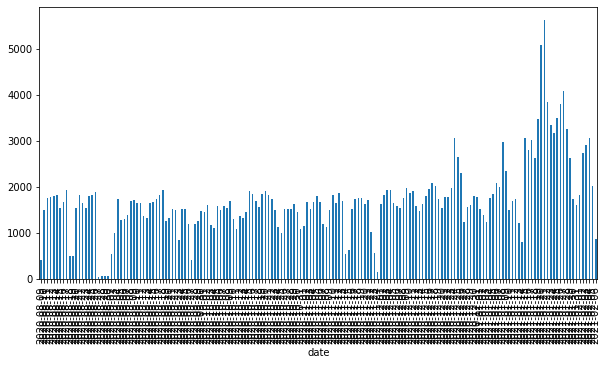

In [4]:
%%time
twitter_ml_utils.show_distribution(df=df_tweets_ready)

In [5]:
%%time

if cell_x:
    df_twitter = twitter_ml_utils.easy_convert_columns(df=df_tweets_ready)

Wall time: 0 ns


In [6]:
%%time

if cell_x:
    df_sd_futured = twitter_ml_utils.get_stocks_based_on_tweets(df=df_twitter, predict_date_str=s.predict_date_str, num_hold_days=s.num_hold_days)

Wall time: 0 ns


In [7]:
if cell_x:
    print(df_sd_futured.shape[0])
    print(list(df_sd_futured.columns))

In [8]:
%%time

if cell_x:
    df_stock_and_quarter, columns_fundy = twitter_ml_utils.combine_with_quarterly_stock_data(df=df_sd_futured)

Wall time: 0 ns


In [9]:
if cell_x:
    print(df_stock_and_quarter.shape[0])
#     print(list(df_stock_and_quarter.columns))

In [10]:
%%time

if cell_x:
#     print(df_twitter.shape[0])
#     print(df_stock_and_quarter.shape[0])
    
    df_nas_tickers_info = ticker_service.get_nasdaq_tickers()
    
    df_merged = twitter_ml_utils.merge_tweets_with_stock_data(df_twitter=df_twitter, 
                                         df_stock_and_quarter=df_stock_and_quarter)

Wall time: 0 ns


In [11]:
if cell_x:
    print(df_merged.shape[0])
    # print(list(df_merged.columns))

In [12]:
%%time

if cell_x:
    print(df_merged.shape[0])

    df_days_until = twitter_ml_utils.add_calendar_info(df=df_merged, 
                                      columns_fundy=columns_fundy,
                                      predict_date_str=s.predict_date_str,
                                      num_hold_days=s.num_hold_days)

    if df_days_until is None:
        raise Exception("Empty result.")

Wall time: 0 ns


In [13]:
%%time
if cell_x:
    print(df_days_until.shape[0])
    df = df_days_until
    df_predict = df[df["date"] == s.predict_date_str].copy()

    if df_predict is None:
        raise Exception("Predict dataframe is empty.")
        
    # print(list(df_predict.columns))

Wall time: 0 ns


In [14]:
%%time

if cell_x:
    df_refined = twitter_service.refine_pool(df=df, min_volume=None, min_price=None, max_price=None)

Wall time: 0 ns


In [15]:
if cell_x:
    print(df_refined.shape[0])
    df_predict = df_refined[df_refined["date"] == s.predict_date_str].copy()
    print(f"df_predict: {df_predict.shape[0]}")
    # print(list(df_predict.columns))

In [16]:
%%time

if cell_x:
    df_ticker_hotted, narrow_cols = twitter_ml_utils.one_hot(df=df_refined)

Wall time: 0 ns


In [17]:
if cell_x:
    print(f"df_ticker_hotted: {df_ticker_hotted.shape[0]}")
    df_predict = df_ticker_hotted[df_ticker_hotted["date"] == s.predict_date_str].copy()
    print(f"df_predict: {df_predict.shape[0]}")
    # print(list(df_predict.columns))

In [18]:
%%time
  
if cell_x:
#     print(list(df_ticker_hotted.columns))
    df_prepped = twitter_ml_utils.prep_predict(df=df_ticker_hotted, predict_date_str=s.predict_date_str)

Wall time: 0 ns


In [19]:
%%time

if cell_x:
    df_train, df_predict = twitter_ml_utils.split_train_predict(df=df_prepped, predict_date_str=s.predict_date_str)
    narrow_cols = twitter_ml_utils.get_train_columns(all_columns=list(df_train.columns))
    print(df_train.shape[0])
    print(df_predict.shape[0])
#     print(narrow_cols)

Wall time: 0 ns


In [20]:
%%time

if cell_x:  
    if df_train is None or df_predict is None or df_predict.shape[0] == 0 or df_train.shape[0] == 0:
        logger.info(f"Not enough data on {s.predict_date_str}")
        raise Exception("Error!")

    df_predict = twitter_ml_utils.train_predict(df_train=df_train, df_predict=df_predict, narrow_cols=narrow_cols)
    
    if df_predict is None:
        raise Exception("predict dataframe is empty.")
        
    print(df_predict.shape[0])

Wall time: 0 ns


In [21]:
if cell_x:
    print(f"df_train: {df_train.shape[0]}")
    print(f"df_predict: {df_predict.shape[0]}")
    total_rows = df_predict.shape[0]
    buy_rows = df_predict[df_predict["prediction"] == 1].shape[0]
    buy_rate = buy_rows/total_rows
    print(f"Purchase rate: {buy_rate:.03f}")

In [22]:
%%time

if cell_x:
    num_buys = df_predict[df_predict["prediction"] == 1].shape[0]
    roi_1_day, roi_5_days = twitter_ml_utils.show_prediction_results(df_predict, s.predict_date_str, s.num_hold_days)
    print(f"{s.predict_date_str}: num_buys: {num_buys}; Roi 1: {roi_1_day}: 5: {roi_5_days}")

Wall time: 0 ns


In [23]:

# if cell_x:
#     roi_day = predict_day(df=df_tweets_for_day, predict_date_str=s.predict_date_str, num_hold_days=s.num_hold_days)
#     print(roi_day)

In [ ]:
%%time
from statistics import mean
from ams.twitter.PredictionParams import TrainParams, PredictionParams, PredictionMode
from ams.twitter import pred_persistence

df_tiny = df_tweets_ready
# df_tiny = df_tweets_ready.sample(frac=.4)

def all_the_days(pp: PredictionParams):
    print("Cleaning prediction file...")
    pred_persistence.clean_prediction_file(pp=pp)

    while pp.validate_prediction_date_str():
        print(f"\nTraining and predicting for {pp.predict_date_str} with {pp.predict_num_rows} rows ...\n")

        is_complete = twitter_ml_utils.predict_day(pp=pp)
        if is_complete:
            break

        pp.subtract_day()
        
print(f"Num tweets: {df_tiny.shape[0]}")

train_params = TrainParams()

pred_params = PredictionParams()
pred_params.prediction_mode = PredictionMode.RealMoneyStockRecommender
pred_params.min_date_str = "2021-02-04"
pred_params.predict_date_str = "2021-02-04"
pred_params.max_date_str = pred_params.predict_date_str
pred_params.num_hold_days = 5
pred_params.df = df_tiny

pred_params.clean_pure_run = False
pred_params.train_params = train_params

all_the_days(pp=pred_params)

Num tweets: 298626
Cleaning prediction file...

Training and predicting for 2021-02-04 with 3065 rows ...

2021-02-05 20:07:19,872 - ams.twitter.twitter_ml_utils - INFO - Finished merging in quarterly stock data.


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
# Add overall ROI ongoing.(?)
# Add EOD (open, close, high, low) to train and predict. But for predict use previous day. Done
# Fix SMA: prev day for open for predict, regular for all other dates: Done
# Add num days from start - already implemented with day_of_year
# Add lookup to previous day's prediction roi - seems to follow on-off-on-off pattern.
# Change to WorldTradingDaily real time quotes (12hr) to substitute for open, low, high, and estimate close. (or just take current)
# WTD not necessary when using historical.
# Test yesterday EOD with 4 day estimate.
# Test with historical purchase day eod data (open, close, high, low)
# Change SMA back to use purchase day-base SMA.
# Reprocess all date with by using sums in Great reduction rather than means.